In [1]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:

data_dir = 'C:/Users/LEGION/Downloads/Adıyaman-AD1 (Turkish side)-20240717T161401Z-001/Adıyaman-AD1 (Turkish side)/dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [4]:
# Load the pretrained VGG19 model
model_ft = models.vgg19(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Training the model
num_epochs = 10
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())

print(f'Best test Acc: {best_acc:4f}')

model_ft.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model_ft.state_dict(), 'best_vgg19_model.pth')

Epoch 0/9
----------
train Loss: 1.2485 Acc: 0.1111
test Loss: 1.1116 Acc: 0.5000
Epoch 1/9
----------
train Loss: 1.1613 Acc: 0.3704
test Loss: 1.0594 Acc: 0.5000
Epoch 2/9
----------
train Loss: 0.9293 Acc: 0.5556
test Loss: 1.0840 Acc: 0.5000
Epoch 3/9
----------
train Loss: 0.7212 Acc: 0.6667
test Loss: 1.1723 Acc: 0.5000
Epoch 4/9
----------
train Loss: 0.7414 Acc: 0.6667
test Loss: 1.2281 Acc: 0.5000
Epoch 5/9
----------
train Loss: 0.7607 Acc: 0.6667
test Loss: 1.2059 Acc: 0.5000
Epoch 6/9
----------
train Loss: 0.6589 Acc: 0.6667
test Loss: 1.1248 Acc: 0.5000
Epoch 7/9
----------
train Loss: 0.6072 Acc: 0.6667
test Loss: 1.0022 Acc: 0.6667
Epoch 8/9
----------
train Loss: 0.4770 Acc: 0.7037
test Loss: 0.8896 Acc: 0.6667
Epoch 9/9
----------
train Loss: 0.4027 Acc: 0.8519
test Loss: 0.8100 Acc: 0.6667
Best test Acc: 0.666667


In [6]:
# Grad-CAM Implementation
def grad_cam(input_image, model, target_layer_names, class_idx=None):
    model.eval()
    features_blobs = []
    gradients = []

    def hook_feature(module, input, output):
        features_blobs.append(output.cpu().data.numpy())
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].cpu().data.numpy())
    
    model._modules.get(target_layer_names).register_forward_hook(hook_feature)
    model._modules.get(target_layer_names).register_backward_hook(backward_hook)
    
    output = model(input_image)
    if class_idx is None:
        class_idx = np.argmax(output.cpu().data.numpy())
    
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0][class_idx] = 1
    one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    grads_val = gradients[0]
    target = features_blobs[0]
    weights = np.mean(grads_val, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

In [7]:
# Example of using the Grad-CAM
model_ft.eval()
inputs, classes = next(iter(dataloaders['test']))
inputs = inputs.to(device)
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

Predicted class: damage_type_a
True class: damage_type_c


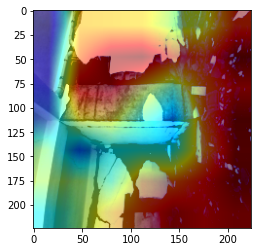

Predicted class: damage_type_a
True class: damage_type_c


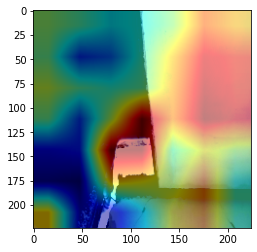

Predicted class: damage_type_b
True class: damage_type_b


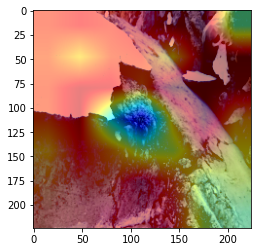

Predicted class: damage_type_a
True class: damage_type_a


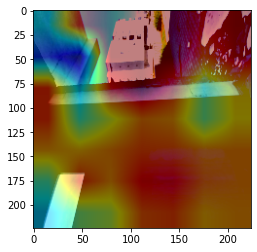

Predicted class: damage_type_a
True class: damage_type_a


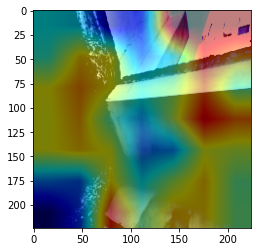

Predicted class: damage_type_a
True class: damage_type_a


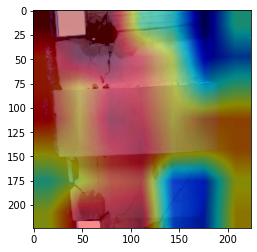

In [14]:
for i in range(len(inputs)):
    input_img = inputs[i].unsqueeze(0)
    cam = grad_cam(input_img, model_ft, 'features', class_idx=preds[i])
    
    # Display the image and Grad-CAM
    img = input_img.cpu().data.numpy().squeeze().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)
    
    print(f'Predicted class: {class_names[preds[i]]}')
    print(f'True class: {class_names[classes[i]]}')
    
    plt.imshow(cam_img)
    plt.show()